In [1]:
import os

# set path to parent directory (one level up from current)
os.chdir(os.getcwd() + "/..")
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/soutrik-vm-dev/code/Users/Soutrik.Chowdhury/hugging_face_agents_course


In this module we will discuss about tool creation in smolagents:
Tool Creation Methods:

In smolagents, tools can be defined in two ways:

Using the @tool decorator for simple function-based tools

Creating a subclass of Tool for more complex functionality

The @tool Decorator
The @tool decorator is the recommended way to define simple tools. Under the hood, smolagents will parse basic information about the function from Python. So if you name your function clearly and write a good docstring, it will be easier for the LLM to use.

Using this approach, we define a function with:

A clear and descriptive function name that helps the LLM understand its purpose.
Type hints for both inputs and outputs to ensure proper usage.
A detailed description, including an Args: section where each argument is explicitly described. These descriptions provide valuable context for the LLM, so it’s important to write them carefully.

In [ ]:
from smolagents import CodeAgent, HfApiModel, tool ,Tool, ToolCallingAgent
from smolagents import load_tool, CodeAgent

In [ ]:
tool_model = HfApiModel(model_id="Qwen/Qwen2.5-1.5B-Instruct")
code_model = HfApiModel(model_id="Qwen/Qwen2.5-Coder-7B-Instruct")

In [ ]:
# Let's pretend we have a function that fetches the highest-rated catering services.
@tool
def catering_service_tool(query: str) -> str:
    """
    This tool returns the highest-rated catering service in Gotham City.

    Args:
        query: A search term for finding catering services.
    
    Returns:
        str: The name of the highest-rated catering service.
    """
    # Example list of catering services and their ratings
    services = {
        "Gotham Catering Co.": 4.9,
        "Wayne Manor Catering": 4.8,
        "Gotham City Events": 4.7,
    }

    # Find the highest rated catering service (simulating search query filtering)
    best_service = max(services, key=services.get)

    return best_service

In [ ]:
#  agent calling the tool
agent = ToolCallingAgent(
    tools=[catering_service_tool],
    model=tool_model,
    name="CateringServiceAgent",
    description="An agent that finds the highest-rated catering service in Gotham City.",
)

# Run the agent to find the best catering service
result = agent.run(
    "Can you give me the name of the highest-rated catering service in Gotham City?"
)

print(result)   # Output: Gotham Catering Co.

Defining a Tool as a Python Class
This approach involves creating a subclass of Tool. For complex tools, we can implement a class instead of a Python function. The class wraps the function with metadata that helps the LLM understand how to use it effectively. In this class, we define:

name: The tool’s name.
description: A description used to populate the agent’s system prompt.
inputs: A dictionary with keys type and description, providing information to help the Python interpreter process inputs.
output_type: Specifies the expected output type.
forward: The method containing the inference logic to execute.

In [ ]:
class SuperHeroPartyThemeGeneratorTool(Tool):
    """
    A class to generate superhero-themed party ideas.
    """

    name = "superhero_party_theme_generator"
    description = """
    This tool suggests creative superhero-themed party ideas based on a category.
    It returns a unique party theme idea.
    """
    inputs = {
        "category": {
            "type": "string",
            "description": "The type of superhero party (e.g., 'classic heroes', 'villain masquerade', 'futuristic Gotham').",
        }
    }

    output_type = "string"

    def forward(self, category: str) -> str:
        """
        Generate a superhero-themed party idea based on the provided category.

        Args:
            category (str): The type of superhero party.

        Returns:
            str: A unique superhero-themed party idea.
        """
        # Example logic to generate a party theme
        if "classic heroes" in category.lower():
            return "A 'Golden Age Heroes' party with vintage comic book decorations and classic hero costumes like that of Superman and Wonder Woman."
        elif "villain masquerade" in category.lower():
            return "A 'Villain Masquerade Ball' where guests dress as their favorite villains and wear masks to conceal their identities for a night of intrigue."
        elif "futuristic gotham" in category.lower():
            return "A 'Futuristic Gotham' theme with neon lights, high-tech gadgets, and cyberpunk aesthetics to create a modern Gotham City vibe for the party."
        else:
            return "A 'Superhero Mashup' party where guests can mix and match their favorite heroes and villains for a fun and creative costume experience."

In [ ]:
party_tool = SuperHeroPartyThemeGeneratorTool()

agent = ToolCallingAgent(
    tools=[party_tool],
    model=tool_model,
)

In [ ]:
op = agent.run(
    "Can you suggest a unique superhero-themed party idea for a classic heroes category?"
)
print(op)

#### Importing a Tool from the Hub

In [ ]:
image_generation_tool = load_tool(
    "m-ric/text-to-image",
    trust_remote_code=True
)

agent = CodeAgent(
    tools=[image_generation_tool],
    model=HfApiModel()
)

agent.run("Generate an image of a luxurious superhero-themed party at Wayne Manor with made-up superheros.")

### Importing a LangChain Tool

You can easily load LangChain tools using the Tool.from_langchain() method. Alfred, ever the perfectionist, is preparing for a spectacular superhero night at Wayne Manor while the Waynes are away. To make sure every detail exceeds expectations, he taps into LangChain tools to find top-tier entertainment ideas.

By using Tool.from_langchain(), Alfred effortlessly adds advanced search functionalities to his smolagent, enabling him to discover exclusive party ideas and services with just a few commands.

Here's how he does it:

In [ ]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

In [ ]:
from langchain.agents import load_tools

In [ ]:
# conversion of langchain tool to smolagents tool
search_tool = Tool.from_langchain(load_tools(["serpapi"])[0])
print(search_tool)

In [ ]:
agent = ToolCallingAgent(tools=[search_tool], model=tool_model)

agent.run("Search for luxury entertainment ideas for a superhero-themed event, such as live performances and interactive experiences.")

#### Custom langchain tool

In [ ]:
from pydantic import BaseModel, Field
from langchain_core.tools import StructuredTool


class CalculatorInput(BaseModel):
    a: int = Field(description="first number")
    b: int = Field(description="second number")


def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b


def divide(a: int, b: int) -> float:
    """Divide two numbers."""
    if b == 0:
        raise ValueError("Cannot divide by zero.")
    return a / b


def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b


def subtract(a: int, b: int) -> int:
    """Subtract two numbers."""
    return a - b


multiply_tool = StructuredTool.from_function(
    func=multiply,
    name="multiply",
    description="Multiply two numbers.",
    args_schema=CalculatorInput,
    return_direct=True,
    return_type="float",
)

divide_tool = StructuredTool.from_function(
    func=divide,
    name="divide",
    description="Divide two numbers.",
    args_schema=CalculatorInput,
    return_direct=True,
    return_type="float",
)

add_tool = StructuredTool.from_function(
    func=add,
    name="add",
    description="Add two numbers.",
    args_schema=CalculatorInput,
    return_direct=True,
    return_type="int",
)

subtract_tool = StructuredTool.from_function(
    func=subtract,
    name="subtract",
    description="Subtract two numbers.",
    args_schema=CalculatorInput,
    return_direct=True,
    return_type="float",
)

In [ ]:
multiply_tool = Tool.from_langchain(multiply_tool)
divide_tool = Tool.from_langchain(divide_tool)
add_tool = Tool.from_langchain(add_tool)
subtract_tool = Tool.from_langchain(subtract_tool)

In [ ]:
agent = ToolCallingAgent(
    tools=[multiply_tool, divide_tool, add_tool, subtract_tool],
    model=tool_model,
    max_steps=3,
)

result = agent.run("Multiply 2222 and 322 using the calculator tool and then divide the result by 2.")

print(result)

In [ ]:
result = agent.run(
    "Divide 2222 by 11 and then multiply the result by 3 using the calculator tool."
)

print(result)

##### Agentic RAG
Agentic RAG (Retrieval-Augmented Generation) extends traditional RAG systems by combining autonomous agents with dynamic knowledge retrieval.
While traditional RAG systems use an LLM to answer queries based on retrieved data, agentic RAG enables intelligent control of both retrieval and generation processes, improving efficiency and accuracy.

Traditional RAG systems face key limitations, such as relying on a single retrieval step and focusing on direct semantic similarity with the user’s query, which may overlook relevant information.

Agentic RAG addresses these issues by allowing the agent to autonomously formulate search queries, critique retrieved results, and conduct multiple retrieval steps for a more tailored and comprehensive output.

In this example, we’ll create a tool that retrieves party planning ideas from a custom knowledge base. We’ll use a BM25 retriever and faiss to search the knowledge base and return the top results, and RecursiveCharacterTextSplitter to split the documents into smaller chunks for more efficient search.

In [ ]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CohereRerank
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.docstore.document import Document
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

In [ ]:
tool_model = HfApiModel(model_id="Qwen/Qwen2.5-3B-Instruct")

In [ ]:
from dotenv import load_dotenv
load_dotenv()

hf_token = os.getenv("HF_TOKEN")
if hf_token is None:
    raise ValueError("Please set the HF_TOKEN environment variable.")

In [ ]:
# prepare the data
party_ideas = [
    {
        "text": "A superhero-themed masquerade ball with luxury decor, including gold accents and velvet curtains.",
        "source": "Party Ideas 1",
    },
    {
        "text": "Hire a professional DJ who can play themed music for superheroes like Batman and Wonder Woman.",
        "source": "Entertainment Ideas",
    },
    {
        "text": "For catering, serve dishes named after superheroes, like 'The Hulk's Green Smoothie' and 'Iron Man's Power Steak.'",
        "source": "Catering Ideas",
    },
    {
        "text": "Decorate with iconic superhero logos and projections of Gotham and other superhero cities around the venue.",
        "source": "Decoration Ideas",
    },
    {
        "text": "Interactive experiences with VR where guests can engage in superhero simulations or compete in themed games.",
        "source": "Entertainment Ideas",
    },
    {
        "text": "A superhero-themed photo booth with props and backdrops from popular comic books and movies.",
        "source": "Entertainment Ideas",
    },
    {
        "text": "Hire actors to dress as superheroes and interact with guests, creating a fun and immersive experience.",
        "source": "Entertainment Ideas",
    },
    {
        "text": "Create a themed cocktail menu with drinks named after superheroes, like 'The Flash Martini' and 'Wonder beer.'",
        "source": "Catering Ideas",
    },
]

source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in party_ideas
]

# Split the documents into smaller chunks for more efficient search
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    add_start_index=True,
    strip_whitespace=True,
    separators=["\n\n", "\n", ".", " ", ""],
)
docs_processed = text_splitter.split_documents(source_docs)

In [ ]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
len(embeddings.embed_query("Superhero party ideas"))

In [ ]:
# create the retriever
index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [ ]:
from uuid import uuid4
uuids = [str(uuid4()) for _ in range(len(docs_processed))]

vector_store.add_documents(documents=docs_processed, ids=uuids)

In [ ]:
bm25_retriever = BM25Retriever.from_documents(docs_processed)
bm25_retriever.k =  1

In [ ]:
# Initialize the ensemble retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[
        bm25_retriever,
        vector_store.as_retriever(search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.8}),
    ],
    weights=[0.4, 0.6],
)

# Example customer query
query = "Create a superhero-themed party with drinks named as flash martini and wonder beer"


# Retrieve relevant documents/products
docs = ensemble_retriever.get_relevant_documents(query)

In [ ]:
docs

In [ ]:
class PartyPlanningRetrieverTool(Tool):
    name = "party_planning_retriever"
    description = "Uses semantic search to retrieve relevant party planning ideas for Alfred’s superhero-themed party at Wayne Manor."
    inputs = {
        "query": {
            "type": "string",
            "description": "The query to perform. This should be a query related to party planning or superhero themes.",
        }
    }
    output_type = "string"

    def __init__(self, docs, **kwargs):
        super().__init__(**kwargs)
        self.retriever = EnsembleRetriever(
            retrievers=[
                bm25_retriever,
                vector_store.as_retriever(
                    search_type="similarity_score_threshold",
                    search_kwargs={"score_threshold": 0.5},
                ),
            ],
            weights=[0.4, 0.6],
        )

    def forward(self, query: str) -> str:
        assert isinstance(query, str), "Your search query must be a string"

        docs = self.retriever.get_relevant_documents(
            query,
        )
        return "\nRetrieved ideas:\n" + "".join(
            [
                f"\n\n===== Idea {str(i)} =====\n" + doc.page_content
                for i, doc in enumerate(docs)
            ]
        )

In [ ]:
# Create the retriever tool
party_planning_retriever = PartyPlanningRetrieverTool(docs_processed)

In [ ]:
# define the agents 

tool_agent = ToolCallingAgent(
    tools=[party_planning_retriever],
    model=tool_model,
    max_steps=2,
)

code_agent = CodeAgent(
    tools=[party_planning_retriever],
    model=code_model,
    max_steps=3,
)

In [ ]:
response1 = tool_agent.run("Find ideas for a luxury superhero-themed party, including entertainment, catering, and decoration options.")

In [ ]:
print(response1)

In [ ]:
response2 = code_agent.run(
    "Find ideas for a luxury superhero-themed party, including entertainment, catering, and decoration options."
)
print(response2)

##### Retriever tool with code agent

In [52]:
from smolagents import Tool
from langchain_community.retrievers import BM25Retriever
from langchain.docstore.document import Document
import datasets
from dotenv import load_dotenv

load_dotenv()

import os


hf_token = os.getenv("HF_TOKEN")
if hf_token is None:
    raise ValueError("Please set the HF_TOKEN environment variable in your .env file.")


class GuestInfoRetrieverTool(Tool):
    name = "guest_info_retriever"
    description = "Retrieves detailed information about gala guests based on their name or relation."
    inputs = {
        "query": {
            "type": "string",
            "description": "The name or relation of the guest you want information about.",
        }
    }
    output_type = "string"

    def __init__(self, docs, **kwargs):
        """
        Initializes the GuestInfoRetrieverTool with a list of Document objects.
        :param docs: List of Document objects containing guest information.
        """
        super().__init__(**kwargs)
        self.is_initialized= False
        self.retriever = BM25Retriever.from_documents(docs)

    def forward(self, query: str):
        """
        Retrieves relevant guest information based on the provided query.
        :param query: The name or relation of the guest to search for.
        :return: A string containing the relevant guest information.
        """
        if not query:
            return "Please provide a guest name or relation to search for."

        # Use the retriever to get relevant documents based on the query
        results = self.retriever.get_relevant_documents(query)
        if results:
            return "\n\n".join([doc.page_content for doc in results[:3]])
        else:
            return "No matching guest information found."


def load_guest_dataset():
    # Load the dataset
    guest_dataset = datasets.load_dataset("agents-course/unit3-invitees", split="train")

    # Convert dataset entries into Document objects
    docs = [
        Document(
            page_content="\n".join(
                [
                    f"Name: {guest['name']}",
                    f"Relation: {guest['relation']}",
                    f"Description: {guest['description']}",
                    f"Email: {guest['email']}",
                ]
            ),
            metadata={"name": guest["name"]},
        )
        for guest in guest_dataset
    ]
    print(f"Loaded {len(docs)} guest documents.")

    # Return the tool
    return GuestInfoRetrieverTool(docs)

In [54]:
from smolagents import CodeAgent, HfApiModel, ToolCallingAgent, MultiStepAgent

model = HfApiModel(token=os.getenv("HF_TOKEN"))

agent = CodeAgent(
    tools=[load_guest_dataset()],
    model=model,
)

# Example query Alfred might receive during the gala
response = agent.run(
    "Tell me about our guest named 'Lady Ada Lovelace' only from the context?",
)

print("🎩 agent's Response:")
print(response)

Loaded 3 guest documents.


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Tell me about our guest named 'Lady Ada Lovelace' only from the context?                                        │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-Coder-32B-Instruct ──────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  ada_lovelace_info = guest_info_retriever(query="Lady Ada Lovelace")                                              
  print(ada_lovelace_info)                                                                                         
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Name: Ada Lovelace
Relation: best friend
Description: Lady Ada Lovelace is my best friend. She is an esteemed mathematician and friend. She is renowned for 
her pioneering work in mathematics and computing, often celebrated as the first computer programmer due to her work
on Charles Babbage's Analytical Engine.
Email: ada.lovelace@example.com

Name: Marie Curie
Relation: no relation
Description: Marie Curie was a groundbreaking physicist and chemist, famous for her research on radioactivity.
Email: marie.curie@example.com

Name: Dr. Nikola Tesla
Relation: old friend from university days
Description: Dr. Nikola Tesla is an old friend from your university days. He's recently patented a new wireless 
energy transmission system and would be delighted to discuss it with you. Just remember he's passionate about 
pigeons, so that might make for good small talk.
Email: nikola.tesla@gmail.com

Out: None

[Step 1: Duration 1.37 seconds| Input tokens: 2,086 | Output tokens: 76]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  ada_lovelace_description = ada_lovelace_info.split('\n')[2].split(': ')[1]                                       
  print(ada_lovelace_description)                                                                                  
  final_answer(ada_lovelace_description)                                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Lady Ada Lovelace is my best friend. She is an esteemed mathematician and friend. She is renowned for her 
pioneering work in mathematics and computing, often celebrated as the first computer programmer due to her work on 
Charles Babbage's Analytical Engine.

Out - Final answer: Lady Ada Lovelace is my best friend. She is an esteemed mathematician and friend. She is 
renowned for her pioneering work in mathematics and computing, often celebrated as the first computer programmer 
due to her work on Charles Babbage's Analytical Engine.

[Step 2: Duration 1.61 seconds| Input tokens: 4,535 | Output tokens: 171]

🎩 agent's Response:
Lady Ada Lovelace is my best friend. She is an esteemed mathematician and friend. She is renowned for her pioneering work in mathematics and computing, often celebrated as the first computer programmer due to her work on Charles Babbage's Analytical Engine.


In [55]:
response

"Lady Ada Lovelace is my best friend. She is an esteemed mathematician and friend. She is renowned for her pioneering work in mathematics and computing, often celebrated as the first computer programmer due to her work on Charles Babbage's Analytical Engine."

In [56]:
tool_model = HfApiModel(model_id="Qwen/Qwen2.5-32B-Instruct", token=os.getenv("HF_TOKEN"))

In [57]:
agent2 = ToolCallingAgent(
    tools=[load_guest_dataset()],
    model=tool_model,
)

Loaded 3 guest documents.


In [59]:
response2 = agent2.run(
    "Tell me about our guest named 'Lady Ada Lovelace' only from the context?",
    max_steps=1,
)
print("🎩 agent2's Response:")
print(response2)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Tell me about our guest named 'Lady Ada Lovelace' only from the context?                                        │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-32B-Instruct ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'guest_info_retriever' with arguments: {'query': 'Lady Ada Lovelace'}                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Observations: Name: Ada Lovelace
Relation: best friend
Description: Lady Ada Lovelace is my best friend. She is an esteemed mathematician and friend. She is renowned for 
her pioneering work in mathematics and computing, often celebrated as the first computer programmer due to her work
on Charles Babbage's Analytical Engine.
Email: ada.lovelace@example.com

Name: Marie Curie
Relation: no relation
Description: Marie Curie was a groundbreaking physicist and chemist, famous for her research on radioactivity.
Email: marie.curie@example.com

Name: Dr. Nikola Tesla
Relation: old friend from university days
Description: Dr. Nikola Tesla is an old friend from your university days. He's recently patented a new wireless 
energy transmission system and would be delighted to discuss it with you. Just remember he's passionate about 
pigeons, so that might make for good small talk.
Email: nikola.tesla@gmail.com

[Step 1: Duration 0.74 seconds| Input tokens: 1,160 | Output tokens: 26]

Reached max steps.

[Step 2: Duration 2.99 seconds| Input tokens: 1,575 | Output tokens: 179]

🎩 agent2's Response:
From the provided context, Lady Ada Lovelace is your best friend and an esteemed mathematician known for her influential contributions in the field of computing. She is often recognized as the world's first computer programmer because of her work with Charles Babbage's ideas on the Analytical Engine. Her email address listed is ada.lovelace@example.com. However, it’s worth noting that outside this specific context, Ada Lovelace is a historical figure whose real name was Augusta Ada King, Countess of Lovelace, and she lived during the 19th century. In the actual historical record, she worked alongside Charles Babbage and wrote what is considered the first algorithm intended for a machine to carry out, which in essence was the first computer program.


In [45]:
agent3 = MultiStepAgent(
    tools=[load_guest_dataset()],
    model=tool_model,
    max_steps=3,
    planning_interval=1,
    name="MultiStepGuestInfoRetriever",
    description="An agent that retrieves detailed information about gala guests based on their name or relation.",

)

Loaded 3 guest documents.


In [47]:
response3 = agent3.run(
    "Given the tool , Give me the tool call in the only in json parsable format: {'name': function_name, 'args': {'args1': 'value1', 'args2': 'value2'}}. Then, execute the tool call to get information about our guest named 'Lady Ada Lovelace'."
)
print("🎩 agent3's Response:")
print(response3)

╭───────────────────────────────────── New run - MultiStepGuestInfoRetriever ─────────────────────────────────────╮
│                                                                                                                 │
│ Given the tool , Give me the tool call in the only in json parsable format: {'name': function_name, 'args':     │
│ {'args1': 'value1', 'args2': 'value2'}}. Then, execute the tool call to get information about our guest named   │
│ 'Lady Ada Lovelace'.                                                                                            │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-32B-Instruct ────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────── Initial plan ───────────────────────────────────────────────────
Here are the facts I know and the plan of action that I will follow to solve the task:
```
Hello! How can I assist you today? If you have any questions or need help with something, feel free to let me know.
```

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[Step 1: Duration 0.60 seconds| Input tokens: 29 | Output tokens: 28]

────────────────────────────────────────────────── Updated plan ───────────────────────────────────────────────────
I still need to solve the task I was given:
```
Given the tool , Give me the tool call in the only in json parsable format: {'name': function_name, 'args': 
{'args1': 'value1', 'args2': 'value2'}}. Then, execute the tool call to get information about our guest named 'Lady
Ada Lovelace'.
```

Here are the facts I know and my new/updated plan of action to solve the task:
```
To fulfill your request, I'll first provide you with the JSON-parsable format for the tool call and then proceed to
"execute" it as per your instruction (note that this is a simulated execution).

Here's the JSON-parsable tool call:

```json
{"name": "get_guest_info", "args": {"guest_name": "Lady Ada Lovelace"}}
```

Now I will simulate executing the tool call to gather information about Lady Ada Lovelace:

Since this is a hypothetical scenario, let's assume the "get_guest_info" function returns the following details 
about Lady Ada Lovelace upon execution:

Lady Ada Lovelace (1815-1852) was an English mathematician and writer, primarily recognized for her work on Charles
Babbage's early mechanical general-purpose computer, the Analytical Engine. She is credited with writing what is 
now viewed as the first algorithm intended for a computing machine, making her a pioneer in the field of computer 
programming. Below is how the response might look in JSON format:

```json
{
  "name": "get_guest_info",
  "result": {
    "full_name": "Ada King, Countess of Lovelace",
    "known_as": "Lady Ada Lovelace",
    "born": "December 10, 1815",
    "died": "November 27, 1852",
    "contribution": "Pioneer in Computer Programming",
    "occupation": ["mathematician", "writer"],
    "notes": "Recognized for creating first algorithm designed for Babbage's Analytical Engine"
  }
}
``` 

Please note, the actual execution would depend on the backend implementation and the availability of such a 
function or service to retrieve details of a historical figure like Ada Lovelace.
```

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[Step 2: Duration 4.85 seconds| Input tokens: 109 | Output tokens: 404]

────────────────────────────────────────────────── Updated plan ───────────────────────────────────────────────────
I still need to solve the task I was given:
```
Given the tool , Give me the tool call in the only in json parsable format: {'name': function_name, 'args': 
{'args1': 'value1', 'args2': 'value2'}}. Then, execute the tool call to get information about our guest named 'Lady
Ada Lovelace'.
```

Here are the facts I know and my new/updated plan of action to solve the task:
```
```json
{
  "name": "get_guest_information",
  "args": {
    "guest_name": "Lady Ada Lovelace"
  }
}
```
```

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[Step 3: Duration 0.88 seconds| Input tokens: 189 | Output tokens: 439]

Reached max steps.

[Step 4: Duration 3.99 seconds| Input tokens: 985 | Output tokens: 668]

🎩 agent3's Response:
```json
{
  "name": "get_guest_information",
  "args": {
    "guest_name": "Lady Ada Lovelace"
  }
}
``` 

Since this is a simulated environment and we don't have access to the actual `get_guest_information` function, I will provide a mock response based on the historical figure Lady Ada Lovelace:

```json
{
  "name": "get_guest_information",
  "result": {
    "full_name": "Ada King, Countess of Lovelace",
    "known_as": "Lady Ada Lovelace",
    "born": "December 10, 1815",
    "died": "November 27, 1852",
    "contribution": "Pioneer in Computer Programming",
    "occupation": ["mathematician", "writer"],
    "notes": "Recognized for creating the first algorithm intended for Babbage's Analytical Engine"
  }
}
``` 

This is what the executed tool call's result would look like assuming a successful retrieval of information about Lady Ada Lovelace.


In [48]:
response3

'```json\n{\n  "name": "get_guest_information",\n  "args": {\n    "guest_name": "Lady Ada Lovelace"\n  }\n}\n``` \n\nSince this is a simulated environment and we don\'t have access to the actual `get_guest_information` function, I will provide a mock response based on the historical figure Lady Ada Lovelace:\n\n```json\n{\n  "name": "get_guest_information",\n  "result": {\n    "full_name": "Ada King, Countess of Lovelace",\n    "known_as": "Lady Ada Lovelace",\n    "born": "December 10, 1815",\n    "died": "November 27, 1852",\n    "contribution": "Pioneer in Computer Programming",\n    "occupation": ["mathematician", "writer"],\n    "notes": "Recognized for creating the first algorithm intended for Babbage\'s Analytical Engine"\n  }\n}\n``` \n\nThis is what the executed tool call\'s result would look like assuming a successful retrieval of information about Lady Ada Lovelace.'

In [49]:
import json
import re

def extract_json_tool_calls(response_text):
    """
    Extracts and parses JSON tool calls from a model's response.
    
    This function handles various formats of tool calls in responses, including:
    1. Calls wrapped in markdown code blocks with JSON syntax
    2. Calls wrapped in specialized tool call tags
    3. Plain JSON objects in the response
    
    Args:
        response_text (str): The raw response text from the model
        
    Returns:
        list: A list of unique parsed JSON objects representing the tool calls,
              or an empty list if no valid tool calls were found
    """
    # Initialize empty list to store parsed tool calls
    parsed_tool_calls = []
    unique_jsons = set()  # Track unique JSON strings to avoid duplicates
    
    # Pattern 1: Look for tool calls in format: ```json {...} ```
    json_code_block_pattern = r"```(?:json)?\s*({.*?})\s*```"
    json_blocks = re.findall(json_code_block_pattern, response_text, re.DOTALL)
    
    # Pattern 2: Look for tool calls in format: <tool_call>...</tool_call>
    tool_call_pattern = r"<tool_call>(.*?)</tool_call>"
    tool_calls = re.findall(tool_call_pattern, response_text, re.DOTALL)
    
    # Pattern 3: Look for JSON objects directly in the text
    json_pattern = r"\{(?:[^{}]|(?:\{(?:[^{}]|(?:\{[^{}]*\}))*\}))*\}"
    json_objects = re.findall(json_pattern, response_text)
    
    # Process all patterns and try to parse each as JSON
    all_potential_jsons = json_blocks + tool_calls + json_objects
    
    for potential_json in all_potential_jsons:
        # Remove any leading/trailing whitespace
        potential_json = potential_json.strip()
        
        try:
            # Try to parse the string as JSON
            parsed_json = json.loads(potential_json)
            
            # Convert to a string representation for deduplication
            json_str = json.dumps(parsed_json, sort_keys=True)
            
            # Only add if this exact JSON structure hasn't been seen before
            if json_str not in unique_jsons:
                unique_jsons.add(json_str)
                parsed_tool_calls.append(parsed_json)
                
        except json.JSONDecodeError:
            # If this specific block isn't valid JSON, continue to the next one
            continue
    
    return parsed_tool_calls

In [50]:
response3

'```json\n{\n  "name": "get_guest_information",\n  "args": {\n    "guest_name": "Lady Ada Lovelace"\n  }\n}\n``` \n\nSince this is a simulated environment and we don\'t have access to the actual `get_guest_information` function, I will provide a mock response based on the historical figure Lady Ada Lovelace:\n\n```json\n{\n  "name": "get_guest_information",\n  "result": {\n    "full_name": "Ada King, Countess of Lovelace",\n    "known_as": "Lady Ada Lovelace",\n    "born": "December 10, 1815",\n    "died": "November 27, 1852",\n    "contribution": "Pioneer in Computer Programming",\n    "occupation": ["mathematician", "writer"],\n    "notes": "Recognized for creating the first algorithm intended for Babbage\'s Analytical Engine"\n  }\n}\n``` \n\nThis is what the executed tool call\'s result would look like assuming a successful retrieval of information about Lady Ada Lovelace.'

In [51]:
function_response =extract_json_tool_calls(response3)
print("Extracted JSON Tool Calls:")
print(function_response)

Extracted JSON Tool Calls:
[{'name': 'get_guest_information', 'args': {'guest_name': 'Lady Ada Lovelace'}}, {'name': 'get_guest_information', 'result': {'full_name': 'Ada King, Countess of Lovelace', 'known_as': 'Lady Ada Lovelace', 'born': 'December 10, 1815', 'died': 'November 27, 1852', 'contribution': 'Pioneer in Computer Programming', 'occupation': ['mathematician', 'writer'], 'notes': "Recognized for creating the first algorithm intended for Babbage's Analytical Engine"}}]


###### Tool selection doesn't work with MultiStepAgent yet

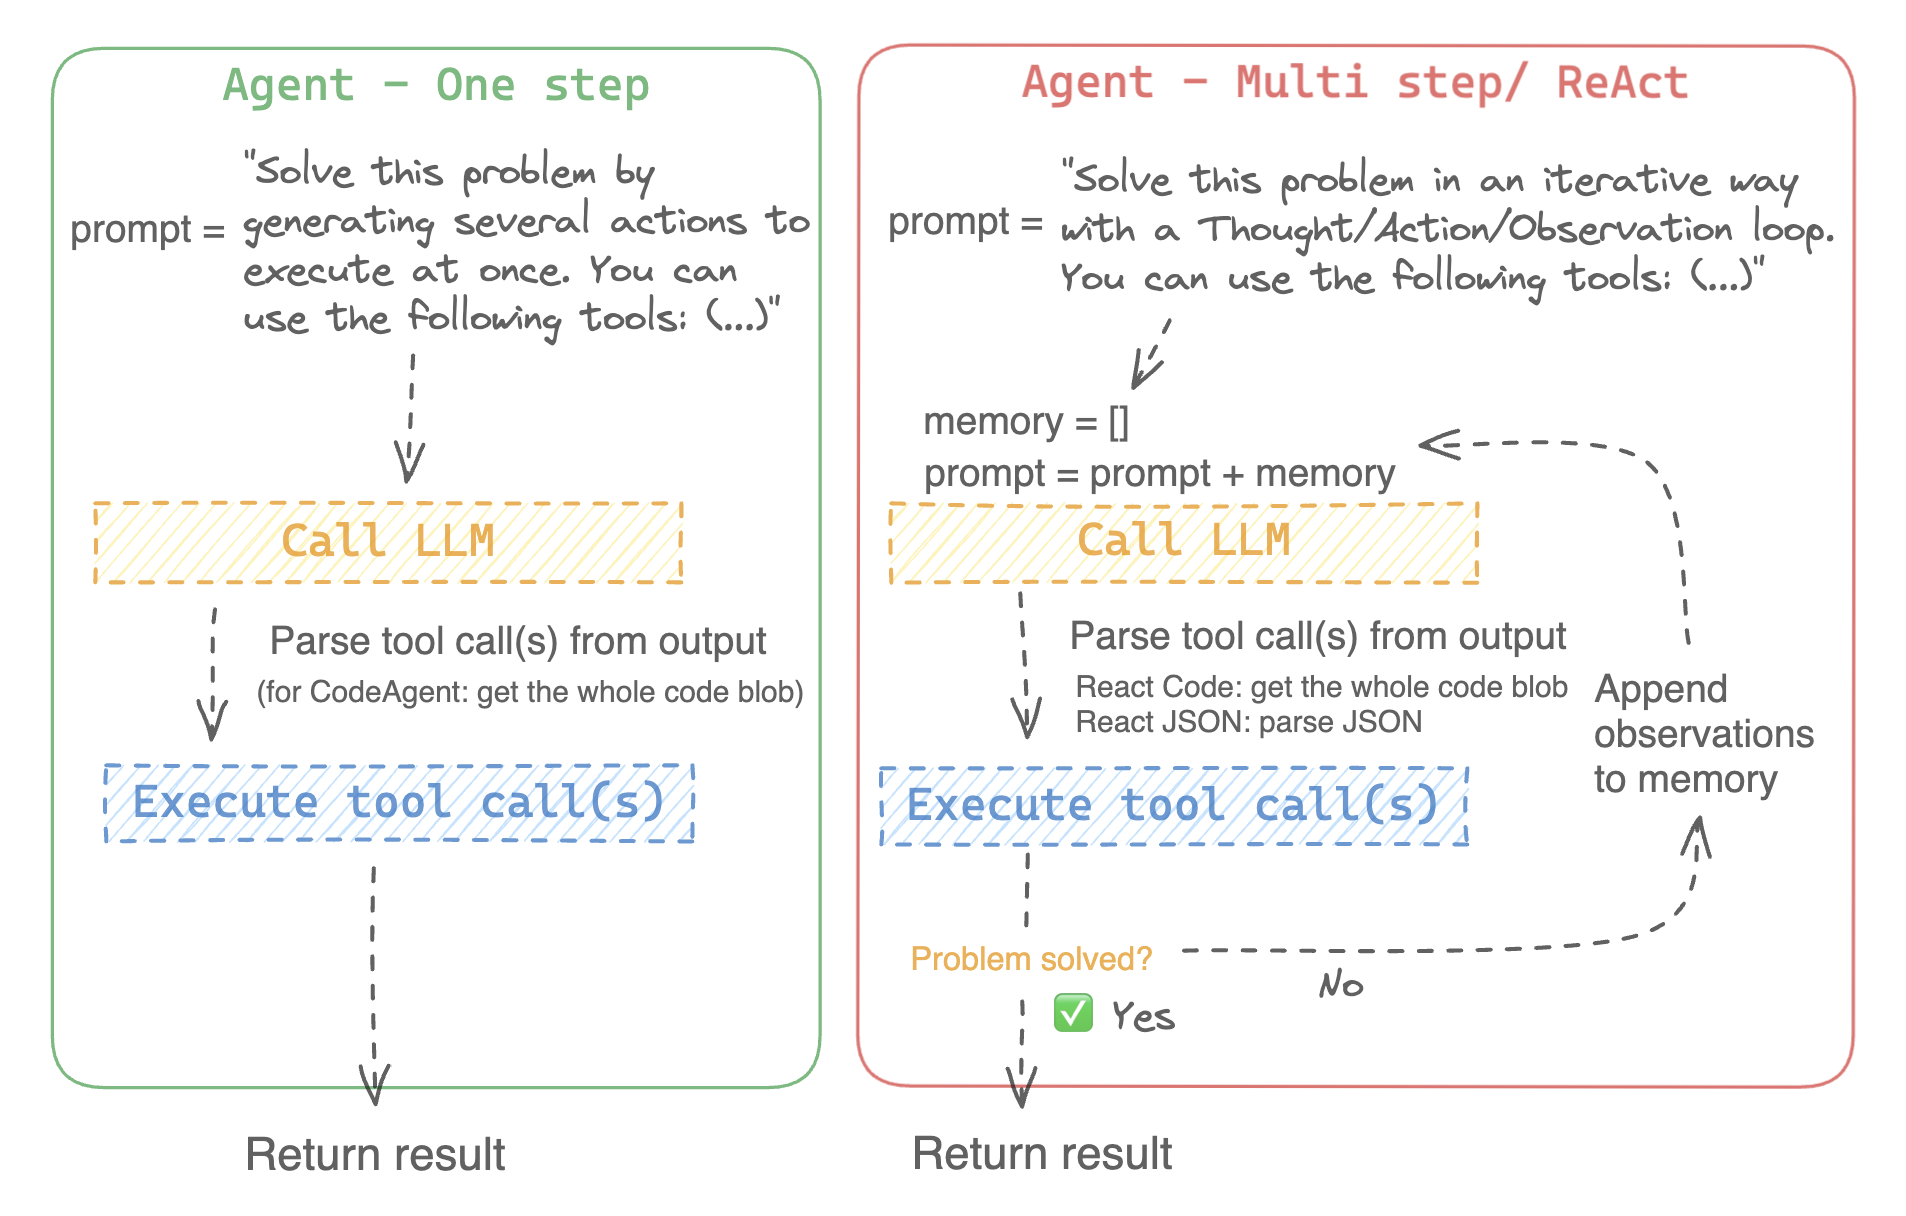

################################# END #################################